In [5]:
tensorboard --logdir "/home/ec2-user/SageMaker/gymnasium-marioV1/results/a2c/exp7/logs/tensorboard/mario_A2C_1" --port 6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
/opt/conda/lib/python3.12/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-28 08:49:12.969520: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 08:49:12.983537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761641353.002186   13489 cuda_dnn.cc:8310] Unable to register cuDNN factory:

Saved plot to: results/a2c/exp7/logs/training_curve.png


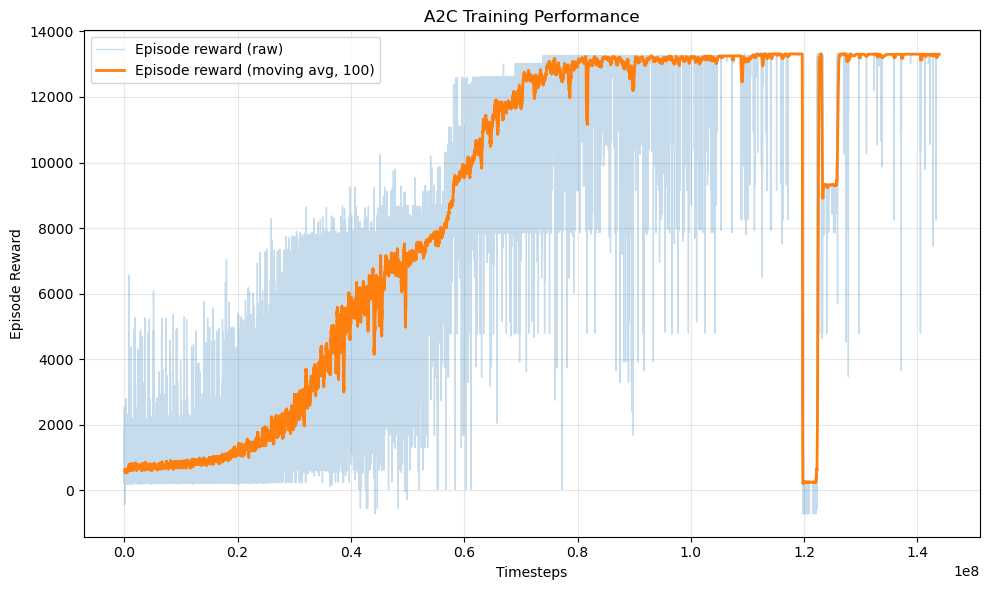

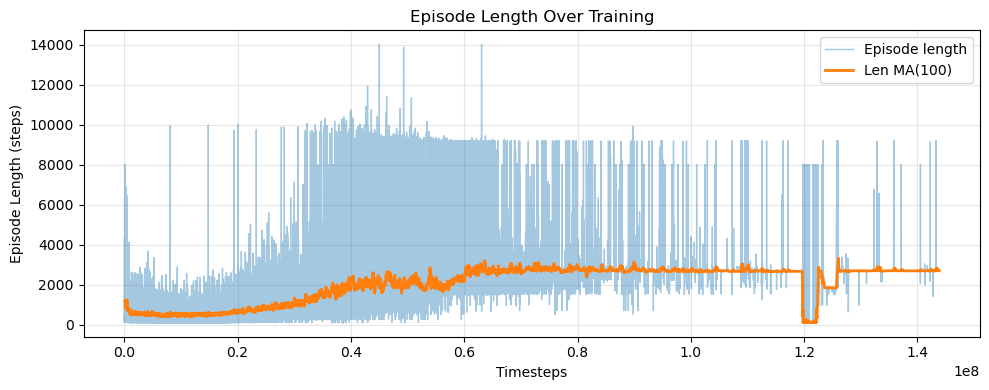

In [16]:
# === Training curve from SB3 monitor + eval logs ===
# Works with Gymnasium/SB3 monitor files produced by Monitor/VecMonitor.
# Requirements: pandas, numpy, matplotlib

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- change only this root ----
EXP_DIR = r"results/a2c/exp7"   # <- your exp7 folder
TRAIN_DIR = os.path.join(EXP_DIR, "logs", "train")
EVAL_DIR  = os.path.join(EXP_DIR, "logs", "eval")
OUT_PNG   = os.path.join(EXP_DIR, "logs", "training_curve.png")

# ---------- helpers ----------
def load_one_monitor_csv(path):
    """
    Read a single SB3/Gymnasium monitor CSV.
    Columns (ignoring commented header lines): r (ep_reward), l (ep_len), t (wall_time_sec)
    """
    # comment="#" skips the header lines that start with '#'
    df = pd.read_csv(path, comment="#")
    # Normalize expected column names just in case
    df = df.rename(columns={"r": "ep_reward", "l": "ep_len", "t": "time"})
    df["source_file"] = os.path.basename(path)
    return df[["ep_reward", "ep_len", "time", "source_file"]]

def load_all_monitors(train_dir):
    files = sorted(glob.glob(os.path.join(train_dir, "*.monitor.csv")))
    if not files:
        raise FileNotFoundError(f"No .monitor.csv files found in {train_dir}")
    dfs = [load_one_monitor_csv(p) for p in files]
    df = pd.concat(dfs, ignore_index=True)
    # Episodes from different envs are interleaved in real time; sort by wall-time
    df = df.sort_values("time", kind="mergesort").reset_index(drop=True)
    # Build cumulative timesteps across all episodes
    df["timesteps"] = df["ep_len"].cumsum()
    return df

def moving_average(x, k=1000):
    if k <= 1:
        return x
    return np.convolve(x, np.ones(k, dtype=float)/k, mode="valid")

def load_eval_npz(eval_dir):
    npz_path = os.path.join(eval_dir, "evaluations.npz")
    if not os.path.exists(npz_path):
        return None
    data = np.load(npz_path, allow_pickle=True)
    # SB3 stores: timesteps (N,), results (N, n_eval_episodes), ep_lengths (N, n_eval_episodes)
    timesteps = data["timesteps"]
    results = data["results"]  # shape [N, n_eval_episodes]
    means = results.mean(axis=1)
    stds  = results.std(axis=1)
    return {"timesteps": timesteps, "mean": means, "std": stds}

# ---------- load data ----------
train_df = load_all_monitors(TRAIN_DIR)
eval_data = load_eval_npz(EVAL_DIR)

# ---------- configure smoothing / plotting ----------
MA_WINDOW = 100  # moving average window over episodes

x_steps = train_df["timesteps"].to_numpy()
y_rew   = train_df["ep_reward"].to_numpy()

y_ma = moving_average(y_rew, k=MA_WINDOW)
x_ma = x_steps[MA_WINDOW-1:]  # align lengths

# ---------- plot ----------
plt.figure(figsize=(10,6))
plt.plot(x_steps, y_rew, alpha=0.25, linewidth=1, label="Episode reward (raw)")
plt.plot(x_ma, y_ma, linewidth=2, label=f"Episode reward (moving avg, {MA_WINDOW})")
'''
if eval_data is not None:
    plt.errorbar(
        eval_data["timesteps"],
        eval_data["mean"],
        yerr=eval_data["std"],
        fmt="o",
        ms=4,
        elinewidth=1,
        capsize=3,
        alpha=0.8,
        label="Eval mean ± std",
    )
'''
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("A2C Training Performance")
plt.legend(loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=150)
print(f"Saved plot to: {OUT_PNG}")
plt.show()

# ---- (optional) also plot episode length trends ----
plt.figure(figsize=(10,4))
plt.plot(train_df["timesteps"], train_df["ep_len"], alpha=0.4, linewidth=1, label="Episode length")
len_ma = moving_average(train_df["ep_len"].to_numpy(), k=MA_WINDOW)
plt.plot(train_df["timesteps"].to_numpy()[MA_WINDOW-1:], len_ma, linewidth=2, label=f"Len MA({MA_WINDOW})")
plt.xlabel("Timesteps")
plt.ylabel("Episode Length (steps)")
plt.title("Episode Length Over Training")
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


Reading from: /home/sagemaker-user/gymnasium-marioV1/results/a2c/exp7


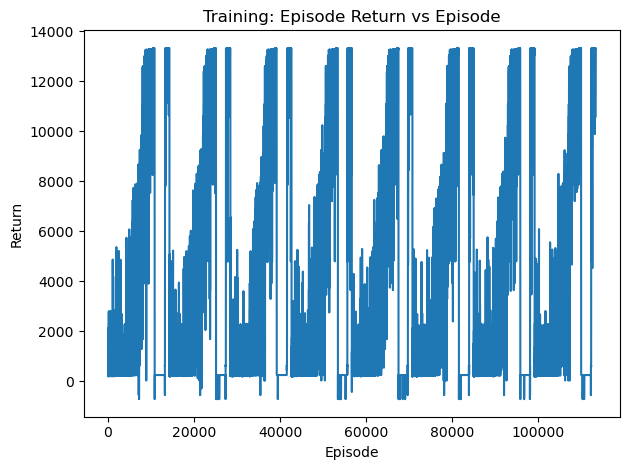

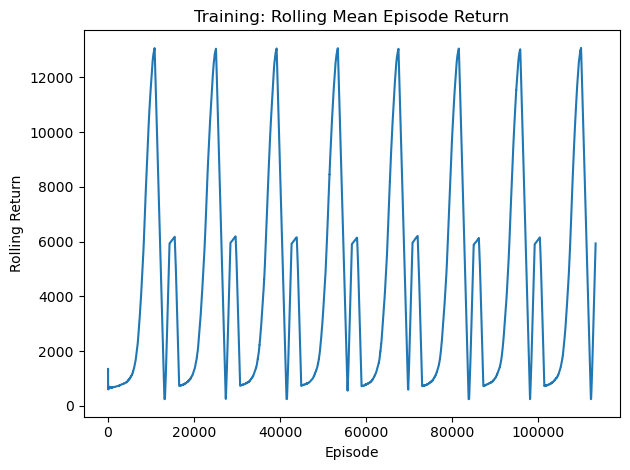

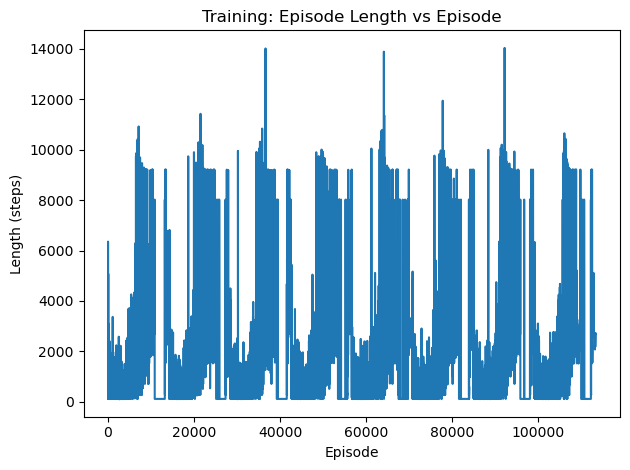

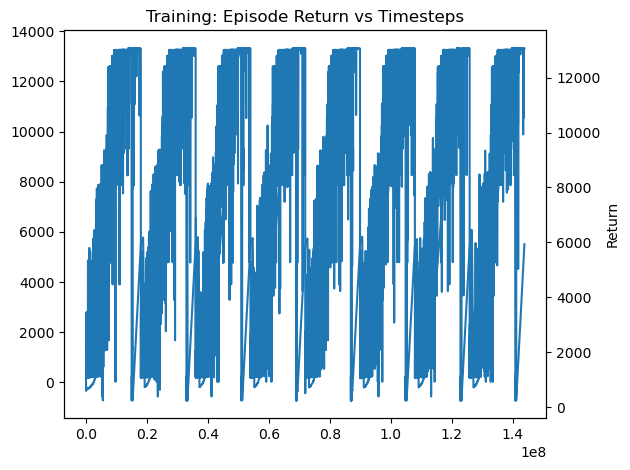

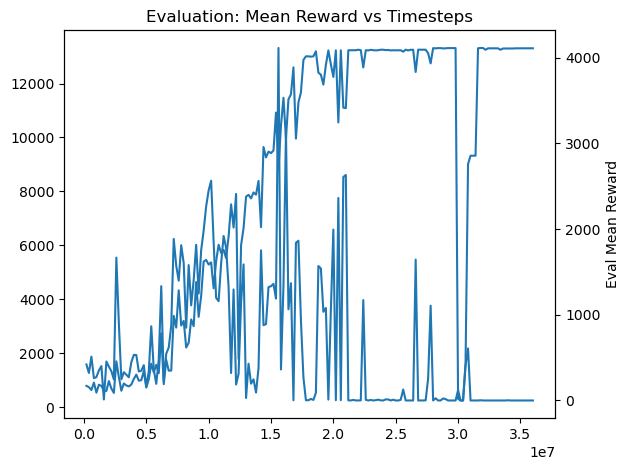

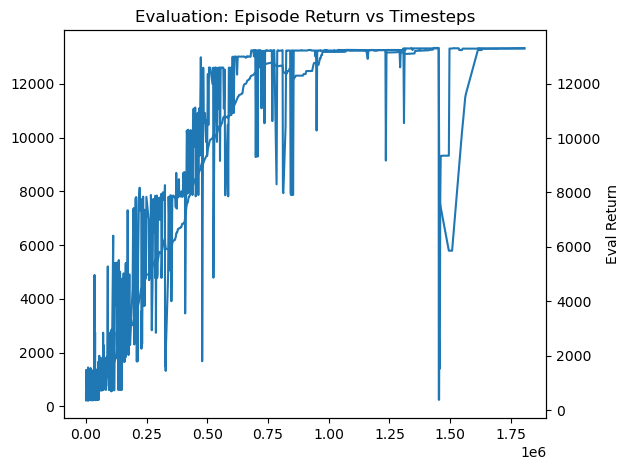

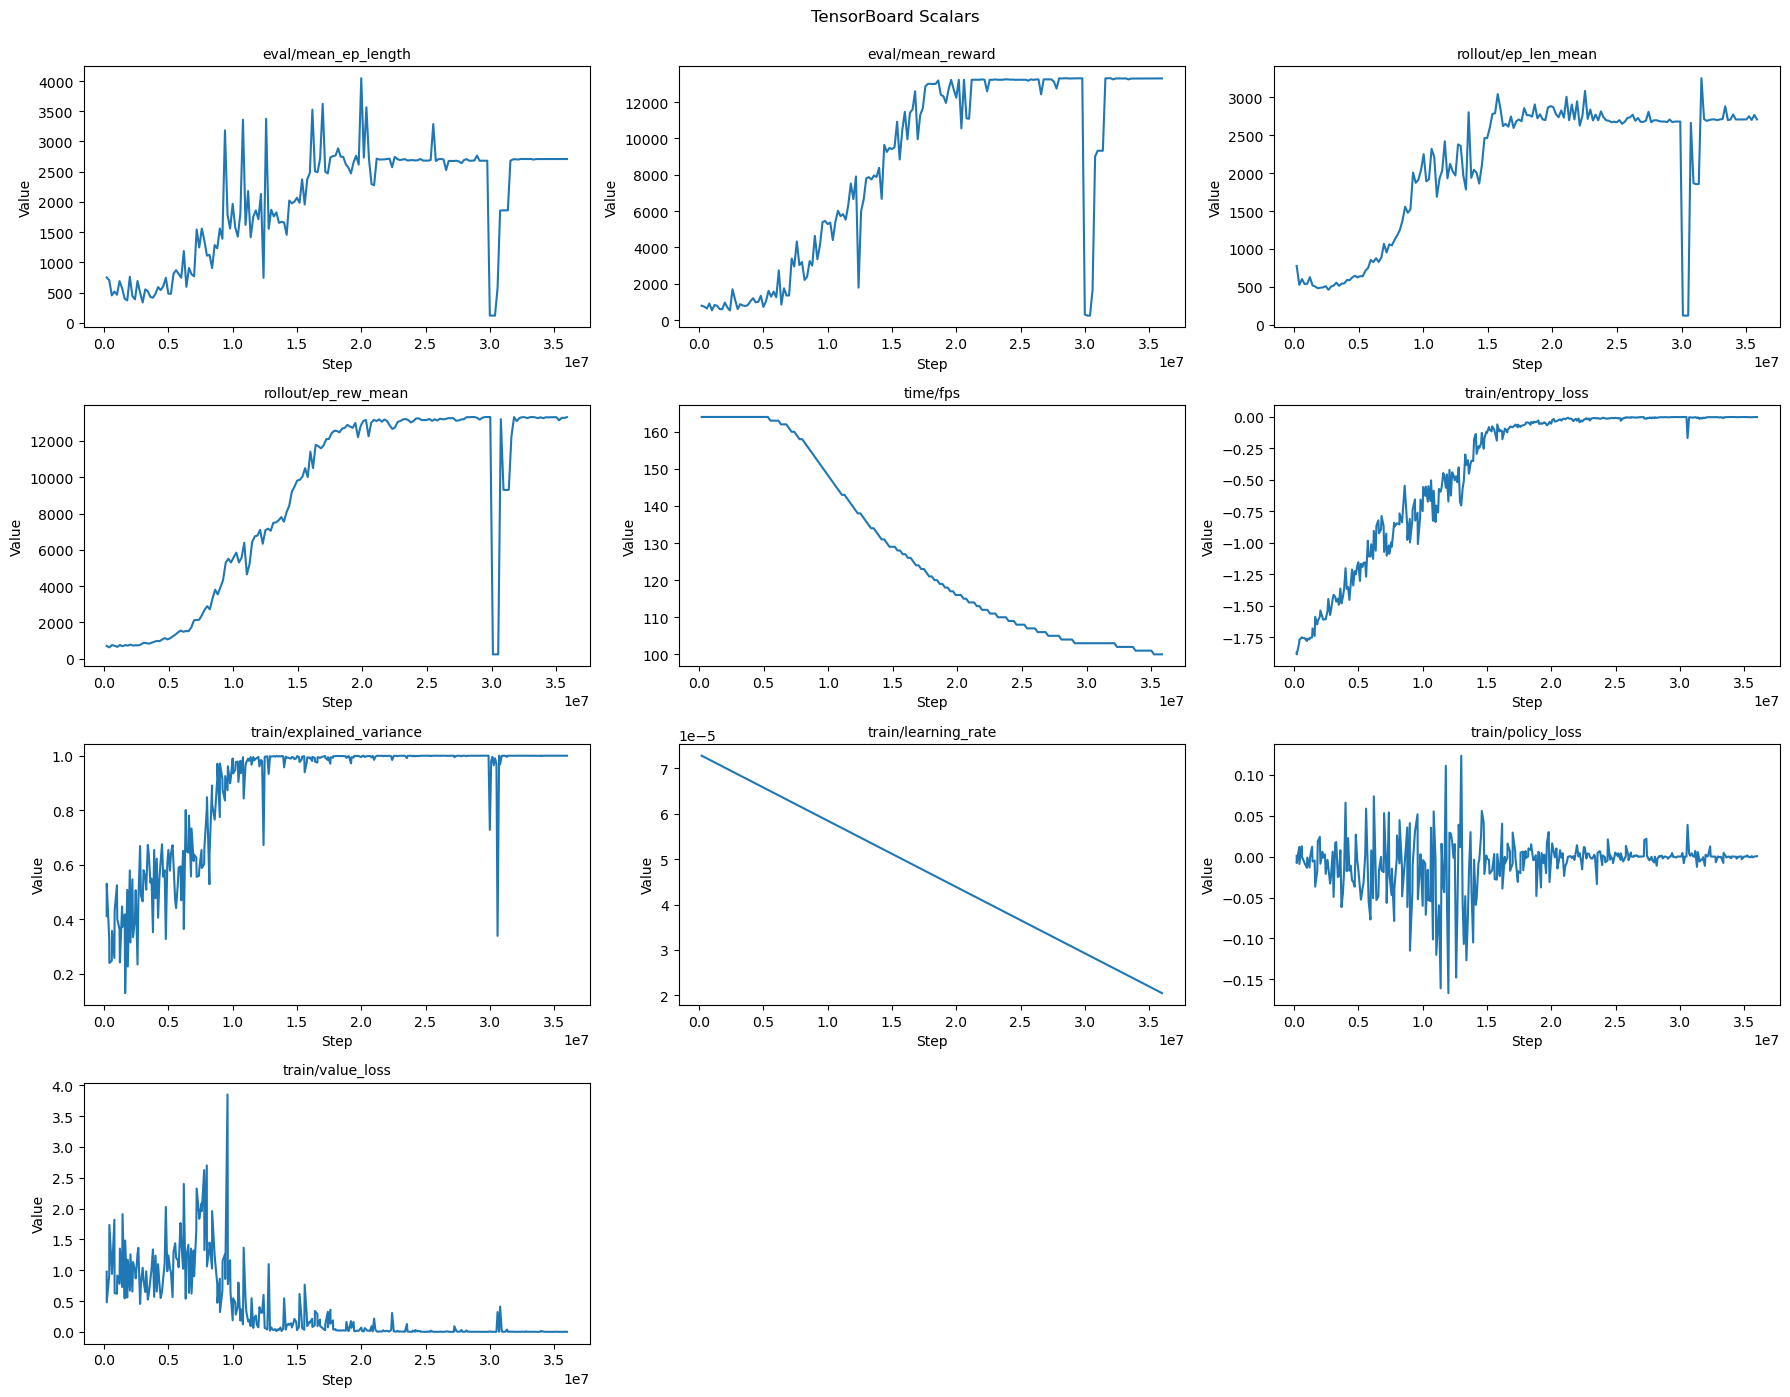

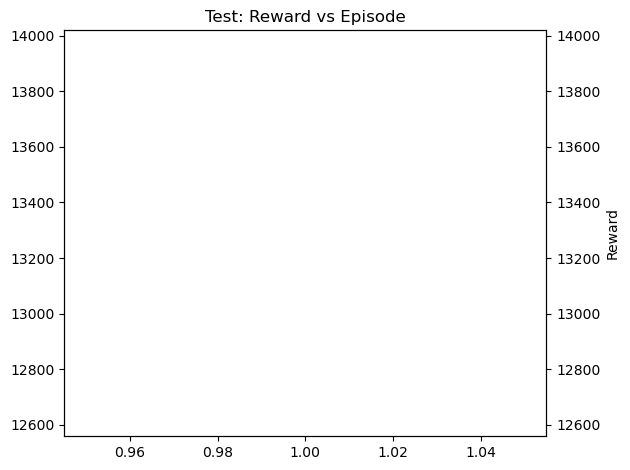

In [14]:
# ===== RL Curves Viewer (no saving) =====
# Works in AWS SageMaker. Shows plots inline.
# Base path: gymnasium-marioV1/results/a2c/exp7

import os, glob, re, math
from pathlib import Path
import numpy as np
import pandas as pd

# (Optional) install missing deps in SageMaker
def _pip(pkgs):
    import importlib, sys, subprocess
    miss=[]
    for p in pkgs:
        m=p.split("==")[0].replace("-","_")
        try: importlib.import_module(m)
        except: miss.append(p)
    if miss:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + miss)

_pip(["matplotlib", "tensorboard", "pandas", "numpy"])

import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# ------------ CONFIG ------------
BASE_DIR = Path("results/a2c/exp7").resolve()
TRAIN_DIR = BASE_DIR / "logs" / "train"
EVAL_DIR  = BASE_DIR / "logs" / "eval"
TB_DIR    = BASE_DIR / "logs" / "tensorboard"
print("Reading from:", BASE_DIR)

# ------------ HELPERS ------------
def to_num(a):
    """Safely convert array-like to numeric float np.array, coercing errors to NaN."""
    s = pd.Series(a)
    s = pd.to_numeric(s, errors="coerce")
    return s.values

def rolling_mean(arr, w):
    arr = to_num(arr)
    if len(arr) == 0: return np.array([])
    w = max(1, int(w))
    # use pandas rolling on numeric series
    return pd.Series(arr).rolling(window=w, min_periods=1).mean().values

def read_sb3_monitors(monitor_paths):
    """Read SB3 monitor CSVs (skip json-header lines) and build merged DataFrame."""
    dfs=[]
    def _key(p):
        m = re.search(r"(\d+)\.monitor\.csv$", p)
        return int(m.group(1)) if m else 0
    for p in sorted(monitor_paths, key=_key):
        df = pd.read_csv(p, comment="#")
        # Ensure expected columns exist; coerce numerics
        for col in ("r","l","t"):
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
        df["__source__"] = Path(p).name
        dfs.append(df)
    if not dfs:
        return pd.DataFrame(columns=["r","l","t","__source__"])
    out = pd.concat(dfs, ignore_index=True)
    out["ep_idx"] = np.arange(1, len(out)+1)
    if "l" in out.columns:
        out["timesteps_cum"] = pd.to_numeric(out["l"], errors="coerce").fillna(0).cumsum()
    else:
        out["timesteps_cum"] = out["ep_idx"]
    return out

def extract_tb_scalars(tb_root):
    """Return dict: tag -> (steps, values) by reading all events under tb_root."""
    tag_map={}
    event_files = sorted(glob.glob(str(tb_root / "**/events.*"), recursive=True))
    if not event_files:
        print("No TensorBoard files under:", tb_root)
        return tag_map
    for ev in event_files:
        try:
            ea = EventAccumulator(ev, size_guidance={"scalars": 0})
            ea.Reload()
            for tag in ea.Tags().get("scalars", []):
                evs = ea.Scalars(tag)
                steps = np.array([e.step for e in evs], dtype=float)
                vals  = np.array([e.value for e in evs], dtype=float)
                if tag in tag_map:
                    s0,v0 = tag_map[tag]
                    steps = np.concatenate([s0, steps])
                    vals  = np.concatenate([v0, vals])
                # sort by step
                idx = np.argsort(steps)
                tag_map[tag] = (steps[idx], vals[idx])
        except Exception as e:
            print(f"Warn: failed to read {ev}: {e}")
    return tag_map

def show_simple_plot(x, y, title, xlabel, ylabel, y2=None, y2label=None):
    plt.figure()
    plt.plot(x, y)
    if y2 is not None:
        ax2 = plt.gca().twinx()
        ax2.plot(x, y2)
        if y2label: ax2.set_ylabel(y2label)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# ------------ 1) TRAINING (monitor CSV) ------------
train_files = glob.glob(str(TRAIN_DIR / "*.monitor.csv"))
train_df = read_sb3_monitors(train_files)

if len(train_df):
    ep   = to_num(train_df["ep_idx"].values)
    rew  = to_num(train_df["r"].values)
    leng = to_num(train_df["l"].values) if "l" in train_df else None
    t_c  = to_num(train_df["timesteps_cum"].values)

    # a) Episode return vs episode
    show_simple_plot(ep, rew, "Training: Episode Return vs Episode", "Episode", "Return")

    # b) Rolling mean return
    rm = rolling_mean(rew, w=max(10, len(rew)//50))
    show_simple_plot(ep, rm, "Training: Rolling Mean Episode Return", "Episode", "Rolling Return")

    # c) Episode length
    if leng is not None:
        show_simple_plot(ep, leng, "Training: Episode Length vs Episode", "Episode", "Length (steps)")

    # d) Return vs cumulative timesteps + rolling
    show_simple_plot(t_c, rew, "Training: Episode Return vs Timesteps", "Timesteps (cum)", "Return",
                     y2=rolling_mean(rew, w=max(10, len(rew)//50)), y2label="Rolling Return")
else:
    print("No training monitor CSVs found at", TRAIN_DIR)

# ------------ 2) EVALUATION (evaluations.npz and eval monitor) ------------
# evaluations.npz (SB3 EvalCallback)
npz_path = EVAL_DIR / "evaluations.npz"
if npz_path.exists():
    data = np.load(npz_path, allow_pickle=True)
    t = data.get("timesteps", None)
    results = data.get("results", None)
    if t is not None and results is not None:
        mean_r = np.mean(results, axis=1)
        std_r  = np.std(results, axis=1)
        show_simple_plot(t, mean_r, "Evaluation: Mean Reward vs Timesteps", "Timesteps", "Eval Mean Reward",
                         y2=std_r, y2label="Eval Reward Std")
else:
    print("No evaluations.npz found (optional).")

# eval monitor CSV (optional)
eval_mon = EVAL_DIR / "0.monitor.csv"
if eval_mon.exists():
    edf = pd.read_csv(eval_mon, comment="#")
    # coerce numerics
    for col in edf.columns:
        edf[col] = pd.to_numeric(edf[col], errors="coerce")
    edf["ep_idx"] = np.arange(1, len(edf)+1)
    if "l" in edf:
        edf["timesteps_cum"] = edf["l"].fillna(0).cumsum()
    else:
        edf["timesteps_cum"] = edf["ep_idx"]
    rrm = rolling_mean(edf["r"].values, w=max(10, len(edf)//20))
    show_simple_plot(edf["timesteps_cum"].values, edf["r"].values,
                     "Evaluation: Episode Return vs Timesteps", "Timesteps (cum)", "Eval Return",
                     y2=rrm, y2label="Rolling Mean")
else:
    print("No eval monitor CSV found (optional).")

# ------------ 3) TENSORBOARD: ALL SCALARS IN ONE SUBPLOT GRID ------------
tb_scalars = extract_tb_scalars(TB_DIR)

if tb_scalars:
    tags = sorted(tb_scalars.keys())
    n = len(tags)
    cols = 2 if n <= 8 else 3
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3.5*rows), squeeze=False, sharex=False)
    ax_list = axes.ravel()

    for i, tag in enumerate(tags):
        s, v = tb_scalars[tag]
        ax = ax_list[i]
        ax.plot(s, v)
        ax.set_title(tag, fontsize=10)
        ax.set_xlabel("Step"); ax.set_ylabel("Value")
    # hide any unused axes
    for j in range(i+1, len(ax_list)):
        fig.delaxes(ax_list[j])
    fig.suptitle("TensorBoard Scalars", y=0.995)
    fig.tight_layout()
    plt.show()
else:
    print("No TensorBoard scalars to plot.")

# ------------ 4) TEST RESULTS (optional CSV) ------------
test_csv = BASE_DIR / "test_results.csv"
if test_csv.exists():
    tdf = pd.read_csv(test_csv)
    # pick reasonable x/y columns; coerce numerics
    def _match(*names):
        for name in names:
            for c in tdf.columns:
                if c.lower() == name: return c
        return None
    ep_col  = _match("episode","episodes","idx") or tdf.columns[0]
    val_col = _match("reward","return","score","value") or tdf.columns[-1]

    x = to_num(tdf[ep_col].values)
    y = to_num(tdf[val_col].values)
    rm = rolling_mean(y, w=max(5, len(y)//20))

    show_simple_plot(x, y, f"Test: {val_col} vs {ep_col}", ep_col, val_col,
                     y2=rm, y2label="Rolling Mean")
else:
    print("No test_results.csv found (optional).")


In [21]:
pwd

'/home/sagemaker-user/gymnasium-marioV1'

In [60]:
import os, pandas as pd, numpy as np

BASE = "results/a2c/exp7"
TEST_CSV = os.path.join(BASE, "test_results.csv")
EVAL_MON = os.path.join(BASE, "logs", "eval", "0.monitor.csv")
TRAIN_DIR = os.path.join(BASE, "logs", "train")

def read_monitor(path):
    return pd.read_csv(path, comment="#")

def coerce_num(s):
    return pd.to_numeric(s, errors="coerce")

# ---------- load TEST results (if present) ----------
test_df = None
if os.path.exists(TEST_CSV):
    raw = pd.read_csv(TEST_CSV, header=0)
    # Two sections: top (episodes), bottom (Metric/Value). Keep numeric rows.
    if "Episode" in raw.columns:
        ep_part = raw[pd.to_numeric(raw["Episode"], errors="coerce").notna()]
        ep_part["Reward"] = coerce_num(ep_part.get("Reward"))
        ep_part["Length"] = coerce_num(ep_part.get("Length"))
        test_df = ep_part[["Reward","Length"]].dropna(how="all")
    # try also to read the summary “Metric/Value” rows
    if "Metric" in raw.columns:
        mv = raw.set_index("Metric")["Value"] if "Value" in raw.columns else None
    else:
        mv = None
else:
    mv = None

# ---------- load EVAL monitor ----------
eval_df = read_monitor(EVAL_MON) if os.path.exists(EVAL_MON) else None
if eval_df is not None:
    # SB3 columns: r (return), l (length), t (time)
    eval_df["r"] = coerce_num(eval_df.get("r"))
    eval_df["l"] = coerce_num(eval_df.get("l"))

# ---------- CUMLATIVE PERFORMANCE ----------
if test_df is not None and len(test_df):
    ep = len(test_df)
    tot = float(test_df["Reward"].sum())
    mean = float(test_df["Reward"].mean())
    tot_len = int(test_df["Length"].sum()) if "Length" in test_df else np.nan
    print("### Cumulative Performance (from test_results.csv)")
    print(f"Episodes: {ep}")
    print(f"Total Reward: {tot:,.2f}")
    print(f"Mean Reward / Episode: {mean:,.2f}")
    if not np.isnan(tot_len):
        print(f"Total Length (steps): {tot_len:,}")
else:
    # fallback: use eval monitor if test is missing
    if eval_df is not None and len(eval_df):
        ep = len(eval_df)
        tot = float(eval_df["r"].sum())
        mean = float(eval_df["r"].mean())
        tot_len = int(eval_df["l"].sum())
        print("### Cumulative Performance (from eval monitor)")
        print(f"Episodes: {ep}")
        print(f"Total Reward: {tot:,.2f}")
        print(f"Mean Reward / Episode: {mean:,.2f}")
        print(f"Total Length (steps): {tot_len:,}")
    else:
        print("### Cumulative Performance\n(no test or eval data found)")

print()  # spacer

# ---------- GENERALIZATION PERFORMANCE (eval monitor) ----------
if eval_df is not None and len(eval_df):
    mean_r = float(eval_df["r"].mean())
    std_r  = float(eval_df["r"].std(ddof=1)) if len(eval_df) > 1 else 0.0
    mean_l = float(eval_df["l"].mean())
    # success rate not available unless you logged flag_get/success
    print("### Generalization Performance (from eval monitor)")
    print(f"Mean Reward: {mean_r:,.2f}")
    print(f"Std Reward: {std_r:,.2f}")
    print(f"Mean Length (steps): {mean_l:,.2f}")
    print("Success Rate: —  (no success/flag column in monitor)")
else:
    print("### Generalization Performance\n(no eval monitor found)")


### Cumulative Performance (from test_results.csv)
Episodes: 1
Total Reward: 13,289.00
Mean Reward / Episode: 13,289.00
Total Length (steps): 2,706

### Generalization Performance (from eval monitor)
Mean Reward: 8,593.34
Std Reward: 5,144.94
Mean Length (steps): 2,006.70
Success Rate: —  (no success/flag column in monitor)


/tmp/ipykernel_1994/3654745971.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep_part["Reward"] = coerce_num(ep_part.get("Reward"))
/tmp/ipykernel_1994/3654745971.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ep_part["Length"] = coerce_num(ep_part.get("Length"))


In [74]:
# === Read EVAL monitor(s) and print all useful values (no saving) ===
import os, glob, numpy as np, pandas as pd

# Point this at your exp folder:
BASE = "results/a2c/exp7"
EVAL_GLOB = os.path.join(BASE, "logs", "eval", "*.monitor*.csv")

def _read_monitor(p):
    # SB3/Monitor files often start with header lines prefixed by '#'
    try:
        df = pd.read_csv(p, comment="#")
    except Exception:
        df = pd.read_csv(p)
    df["_file"] = os.path.basename(p)
    return df

def _num(s):  # safe numeric coercion
    return pd.to_numeric(s, errors="coerce")

# ---- Load all eval monitors ----
paths = sorted(glob.glob(EVAL_GLOB))
if not paths:
    raise FileNotFoundError(f"No eval monitor CSVs found under: {EVAL_GLOB}")

dfs = []
for p in paths:
    try:
        df = _read_monitor(p)
        dfs.append(df)
    except Exception as e:
        print(f"Skip {p}: {e}")

eval_df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
if eval_df.empty:
    raise RuntimeError("Eval monitor loaded but no rows present.")

# ---- Normalize common columns ----
# SB3 Monitor canonical: 'r' (episode return), 'l' (length), 't' (time seconds since start)
for c in ["r","l","t","reward","return","length","x_pos","flag_get","success","is_success","world","stage"]:
    if c in eval_df.columns:
        eval_df[c] = _num(eval_df[c])

# unify reward & length columns
if "r" not in eval_df.columns:
    # fallbacks
    if "reward" in eval_df.columns: eval_df["r"] = _num(eval_df["reward"])
    elif "return" in eval_df.columns: eval_df["r"] = _num(eval_df["return"])
    else: eval_df["r"] = np.nan

if "l" not in eval_df.columns:
    if "length" in eval_df.columns: eval_df["l"] = _num(eval_df["length"])
    else: eval_df["l"] = np.nan

# unify success (if logged via info_keywords)
succ_col = None
for sc in ["flag_get","success","is_success","cleared"]:
    if sc in eval_df.columns:
        succ_col = sc; break
if succ_col is not None:
    eval_df["_succ"] = _num(eval_df[succ_col]).fillna(0).astype(int)
else:
    eval_df["_succ"] = np.nan  # not available

# world/stage (if present)
has_ws = ("world" in eval_df.columns) and ("stage" in eval_df.columns)

# ---- Overall/cumulative metrics ----
episodes = len(eval_df)
r = eval_df["r"].astype(float)
l = eval_df["l"].astype(float)

def fmt(x, nd=2):
    return "—" if (x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x)))) else f"{x:,.{nd}f}"

print("### EVAL — Cumulative Performance")
print(f"Episodes               : {episodes:,}")
print(f"Total Reward           : {fmt(r.sum())}")
print(f"Mean Reward / Episode  : {fmt(r.mean())}")
print(f"Std Reward             : {fmt(r.std(ddof=1) if episodes>1 else 0.0)}")
print(f"Min/Median/Max Reward  : {fmt(r.min())} / {fmt(r.median())} / {fmt(r.max())}")

if l.notna().any():
    print(f"Total Length (steps)   : {int(l.sum())}")
    print(f"Mean Length (steps)    : {fmt(l.mean())}")
    print(f"Min/Median/Max Length  : {fmt(l.min())} / {fmt(l.median())} / {fmt(l.max())}")
else:
    print("Lengths                : —")

# timing / throughput if 't' exists (SB3 monitor 't' is elapsed seconds)
if "t" in eval_df.columns and eval_df["t"].notna().any():
    t_end = float(eval_df["t"].max())
    steps = float(l.sum()) if l.notna().any() else np.nan
    sps = steps / t_end if (t_end and not np.isnan(steps)) else np.nan
    print(f"Wall Time (s)          : {fmt(t_end)}")
    print(f"Throughput (steps/s)   : {fmt(sps)}")

# ---- Success metrics ----
print("\n### EVAL — Success Metrics")
if pd.api.types.is_numeric_dtype(eval_df["_succ"]):
    succ_count = int(eval_df["_succ"].sum())
    succ_rate = 100.0 * succ_count / int(eval_df["_succ"].count()) if int(eval_df["_succ"].count())>0 else np.nan
    print(f"Successes              : {succ_count}/{episodes} ({fmt(succ_rate, 2)}%)")
else:
    print("Success                : — (no success/flag column in eval logs)")

# ---- Per-stage aggregation (if world/stage available) ----
if has_ws:
    grp = eval_df.groupby(["world","stage"], dropna=False)
    per_stage = grp.agg(
        episodes=("r","count"),
        success_rate=("_succ", lambda s: 100.0*s.mean() if pd.api.types.is_numeric_dtype(s) else np.nan),
        mean_reward=("r","mean"),
        std_reward=("r", lambda s: s.std(ddof=1) if len(s)>1 else 0.0),
        mean_len=("l","mean"),
        mean_xpos=("x_pos","mean") if "x_pos" in eval_df.columns else ("r","count"),  # harmless fallback
        max_xpos=("x_pos","max") if "x_pos" in eval_df.columns else ("r","count"),
    ).round(2)
    # pretty print
    print("\n### EVAL — Per-Stage Summary")
    if len(per_stage):
        # cast success_rate nicely with % if present
        if "success_rate" in per_stage.columns and per_stage["success_rate"].notna().any():
            sr = per_stage["success_rate"].apply(lambda v: f"{v:.2f}%" if pd.notna(v) else "—")
            per_stage = per_stage.drop(columns=["success_rate"]).assign(success_rate=sr)
        print(per_stage.to_string())
    else:
        print("(no world/stage rows)")
else:
    print("\n### EVAL — Per-Stage Summary\n(no world/stage columns in eval logs)")

# ---- Best/Worst episodes (by reward, and by x_pos if present) ----
print("\n### EVAL — Best/Worst Episodes")
best_r_idx = r.idxmax(); worst_r_idx = r.idxmin()
print(f"Best Reward            : {fmt(r.iloc[best_r_idx])}  (row {int(best_r_idx)})")
print(f"Worst Reward           : {fmt(r.iloc[worst_r_idx])}  (row {int(worst_r_idx)})")
if "x_pos" in eval_df.columns and eval_df["x_pos"].notna().any():
    xp = eval_df["x_pos"].astype(float)
    bx_idx, wx_idx = xp.idxmax(), xp.idxmin()
    print(f"Max x_pos              : {fmt(xp.iloc[bx_idx])}  (row {int(bx_idx)})")
    print(f"Min x_pos              : {fmt(xp.iloc[wx_idx])}  (row {int(wx_idx)})")

# ---- Rolling summaries (last-window mean) for reward/length
def rolling_last_mean(series, frac=0.1, min_w=5):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0: return np.nan
    w = max(min_w, int(len(s)*frac))
    return s.rolling(window=w, min_periods=1).mean().iloc[-1]

roll_r = rolling_last_mean(r, frac=0.1)
roll_l = rolling_last_mean(l, frac=0.1) if l.notna().any() else np.nan
print("\n### EVAL — Rolling Window (last 10% or >=5)")
print(f"Rolling Reward Mean    : {fmt(roll_r)}")
print(f"Rolling Length Mean    : {fmt(roll_l)}")


### EVAL — Cumulative Performance
Episodes               : 900
Total Reward           : 7,734,006.10
Mean Reward / Episode  : 8,593.34
Std Reward             : 5,144.94
Min/Median/Max Reward  : 218.00 / 10,615.30 / 13,331.70
Total Length (steps)   : 1806027
Mean Length (steps)    : 2,006.70
Min/Median/Max Length  : 116.00 / 2,566.50 / 10,329.00
Wall Time (s)          : 358,257.17
Throughput (steps/s)   : 5.04

### EVAL — Success Metrics
Successes              : 0/900 (—%)

### EVAL — Per-Stage Summary
(no world/stage columns in eval logs)

### EVAL — Best/Worst Episodes
Best Reward            : 13,331.70  (row 702)
Worst Reward           : 218.00  (row 9)

### EVAL — Rolling Window (last 10% or >=5)
Rolling Reward Mean    : 13,302.64
Rolling Length Mean    : 2,709.23


In [75]:
import numpy as np
import pandas as pd

EVAL_NPZ = "results/a2c/exp7/logs/eval/evaluations.npz"  # <- your path

data = np.load(EVAL_NPZ, allow_pickle=True)
files = set(data.files)
# Expected keys: 'timesteps', 'results', 'ep_lengths', optionally 'successes'
timesteps   = data["timesteps"]            if "timesteps"   in files else None
results     = data["results"]              if "results"     in files else None  # shape: (n_eval, n_episodes_per_eval)
ep_lengths  = data["ep_lengths"]           if "ep_lengths"  in files else None  # shape like results
successes   = data["successes"]            if "successes"   in files else None  # same shape; optional

# ---- Flatten per-episode values ----
r_flat  = results.flatten()   if results is not None else np.array([])
l_flat  = ep_lengths.flatten() if ep_lengths is not None else np.array([])
s_flat  = successes.flatten().astype(float) if successes is not None else None

# ---- Basic counts ----
episodes = int(r_flat.size)

def fmt(x, nd=2):
    try:
        if x is None or (isinstance(x, float) and (np.isnan(x) or np.isinf(x))):
            return "—"
        return f"{x:,.{nd}f}"
    except Exception:
        return str(x)

# ---- CUMULATIVE PERFORMANCE ----
tot_reward = float(r_flat.sum()) if episodes else float("nan")
mean_r     = float(r_flat.mean()) if episodes else float("nan")
std_r      = float(r_flat.std(ddof=1)) if episodes > 1 else 0.0
min_r      = float(r_flat.min()) if episodes else float("nan")
median_r   = float(np.median(r_flat)) if episodes else float("nan")
max_r      = float(r_flat.max()) if episodes else float("nan")

if l_flat.size:
    tot_len   = int(l_flat.sum())
    mean_len  = float(l_flat.mean())
    min_len   = float(l_flat.min())
    median_len= float(np.median(l_flat))
    max_len   = float(l_flat.max())
else:
    tot_len = mean_len = min_len = median_len = max_len = None

cum_tbl = pd.DataFrame([{
    "Episodes": episodes,
    "Total Reward": fmt(tot_reward),
    "Mean Reward / Episode": fmt(mean_r),
    "Std Reward": fmt(std_r),
    "Min / Median / Max Reward": f"{fmt(min_r)} / {fmt(median_r)} / {fmt(max_r)}",
    "Total Length (steps)": f"{tot_len:,}" if tot_len is not None else "—",
    "Mean Length (steps)": fmt(mean_len) if mean_len is not None else "—",
    "Min / Median / Max Length": (f"{fmt(min_len)} / {fmt(median_len)} / {fmt(max_len)}"
                                  if min_len is not None else "—"),
}])

print("### Cumulative Performance (from evaluations.npz)")
print(cum_tbl.to_string(index=False))

# ---- GENERALIZATION PERFORMANCE ----
# Overall success rate (if present)
if s_flat is not None and s_flat.size:
    succ_count = int(np.nansum(s_flat))
    succ_rate  = 100.0 * succ_count / int(np.sum(~np.isnan(s_flat)))
    succ_str   = f"{succ_count} / {episodes} ({succ_rate:.2f}%)"
else:
    succ_str   = "—"

# Per-evaluation aggregates over timesteps (useful to see progress)
per_eval_mean_r = results.mean(axis=1) if results is not None else np.array([])
per_eval_std_r  = results.std(axis=1, ddof=1) if results is not None and results.shape[1] > 1 else np.zeros_like(per_eval_mean_r)
per_eval_len    = ep_lengths.mean(axis=1) if ep_lengths is not None else np.array([])

gen_tbl = pd.DataFrame([{
    "Successes": succ_str,
    "Mean Reward (all episodes)": fmt(mean_r),
    "Std Reward (all episodes)": fmt(std_r),
    "Mean Length (steps)": fmt(mean_len) if mean_len is not None else "—",
    "Eval Points": len(per_eval_mean_r) if per_eval_mean_r.size else 0,
}])

print("\n### Generalization Performance (from evaluations.npz)")
print(gen_tbl.to_string(index=False))

# (Optional) show first/last few eval points (mean reward at each saved timestep)
if per_eval_mean_r.size:
    head = min(3, per_eval_mean_r.size)
    tail = min(3, per_eval_mean_r.size - head)
    print("\nFirst eval points (timestep → mean_reward ± std):")
    for i in range(head):
        ts = int(timesteps[i]) if timesteps is not None else i
        print(f"- {ts} → {per_eval_mean_r[i]:,.2f} ± {per_eval_std_r[i]:,.2f}")
    if tail > 0:
        print("Last eval points:")
        for i in range(per_eval_mean_r.size - tail, per_eval_mean_r.size):
            ts = int(timesteps[i]) if timesteps is not None else i
            print(f"- {ts} → {per_eval_mean_r[i]:,.2f} ± {per_eval_std_r[i]:,.2f}")

# (Optional) if successes present, also show overall success and last-eval success
if successes is not None and successes.size:
    per_eval_succ = np.mean(successes, axis=1) * 100.0
    last_succ = per_eval_succ[-1]
    print(f"\nSuccess Rate per eval (last): {last_succ:.2f}%")


### Cumulative Performance (from evaluations.npz)
 Episodes Total Reward Mean Reward / Episode Std Reward      Min / Median / Max Reward Total Length (steps) Mean Length (steps)     Min / Median / Max Length
      900 7,734,006.10              8,593.34   5,144.94 218.00 / 10,615.30 / 13,331.70            1,806,027            2,006.70 116.00 / 2,566.50 / 10,329.00

### Generalization Performance (from evaluations.npz)
Successes Mean Reward (all episodes) Std Reward (all episodes) Mean Length (steps)  Eval Points
        —                   8,593.34                  5,144.94            2,006.70          180

First eval points (timestep → mean_reward ± std):
- 200000 → 787.00 ± 469.63
- 400000 → 738.60 ± 358.78
- 600000 → 632.00 ± 571.88
Last eval points:
- 35600000 → 13,308.80 ± 0.00
- 35800000 → 13,308.80 ± 0.00
- 36000000 → 13,308.80 ± 0.00


In [78]:
import pandas as pd
import numpy as np
import os

EVAL_MON = "results/a2c/exp7/logs/eval/0.monitor.csv"

df = pd.read_csv(EVAL_MON, comment="#")  # SB3 monitor has '#' header lines
last = df.tail(1).copy()

# Coerce common fields to numeric if present
for c in ["r","l","t","x_pos","flag_get","world","stage","success","is_success"]:
    if c in last.columns:
        last[c] = pd.to_numeric(last[c], errors="coerce")

# Pretty print all columns for the final episode
print("=== Final episode (from eval monitor) ===")
for col, val in last.iloc[0].items():
    print(f"{col}: {val}")


=== Final episode (from eval monitor) ===
r: 13308.8
l: 2710.0
t: 358257.171273


In [79]:
import numpy as np

NPZ = "results/a2c/exp7/logs/eval/evaluations.npz"
data = np.load(NPZ, allow_pickle=True)

timesteps  = data["timesteps"]             # shape: (n_eval,)
results    = data["results"]               # shape: (n_eval, n_episodes_per_eval)
ep_lengths = data["ep_lengths"]            # same shape
successes  = data["successes"] if "successes" in data.files else None

i = -1  # last eval index
j = -1  # last episode within that eval

final = {
    "eval_timestep": int(timesteps[i]) if timesteps.size else None,
    "episode_reward": float(results[i, j]),
    "episode_length": int(ep_lengths[i, j]),
    "success": (bool(successes[i, j]) if successes is not None else None),
}
print(final)


{'eval_timestep': 36000000, 'episode_reward': 13308.8, 'episode_length': 2710, 'success': None}


In [86]:
from mario_cnn_a2c_2 import make_mario_env   # your factory
from stable_baselines3 import A2C
import gymnasium as gym
import numpy as np

BEST_MODEL = "results/a2c/exp7/models/best_model/best_model.zip"
EID = "SuperMarioBros-1-1-v0"  # pick the stage you care about

# Build single-env VecEnv (do not pass render_mode to your factory)
env = make_mario_env(EID, n_envs=1, seed=None, max_episode_steps=None,
                     frame_stack=4, use_vec_normalize=False,
                     wrapper_kwargs=None, vec_normalize_kwargs=None, env_kwargs=None)

# Load model; if your ZIP lacks spaces, supply env and custom_objects
model = A2C.load(BEST_MODEL, env=env, custom_objects={
    "observation_space": env.observation_space,
    "action_space": env.action_space,
    "_last_obs": None, "_last_episode_starts": None, "_last_original_obs": None,
})

obs = env.reset()
done, R, L, cleared, max_x, last_info = False, 0.0, 0, False, 0.0, {}
while not done:
    action, _ = model.predict(obs, deterministic=False)  # try False for A2C
    obs, rewards, dones, infos = env.step(action)        # VecEnv API
    R += float(rewards[0]); L += 1
    info0 = infos[0] if isinstance(infos, (list,tuple)) else infos
    last_info = info0
    max_x = max(max_x, float(info0.get("x_pos", 0.0)))
    cleared = bool(info0.get("flag_get", False)) or cleared
    done = bool(dones[0])
env.close()

final = {
    "episode_reward": R,
    "episode_length": L,
    "flag_get": int(cleared),
    "max_x_pos": max_x,
    "world": last_info.get("world"),
    "stage": last_info.get("stage"),
}
print("=== Final episode (fresh eval) ===")
for k,v in final.items(): print(f"{k}: {v}")

New stage reached: 2
New stage reached: 3
=== Final episode (fresh eval) ===
episode_reward: 13289.000219881535
episode_length: 677
flag_get: 0
max_x_pos: 3157.0
world: 1
stage: 3


In [95]:
# inside your eval loop, after an episode ends
agent_steps = L  # your loop counter
skip = getattr(env.envs[0].unwrapped, "skip", 4)  # fallback 4 if not present
frames = agent_steps * skip

print(f"Episode: reward={R:.2f}, agent_steps={agent_steps}, frames≈{frames}, flag_get={cleared}")


Episode: reward=13289.00, agent_steps=677, frames≈2708, flag_get=False
